### Problem statement

Development of an expert system is proposed to help students decide the profession that best suits them. The inputs are:

• Results in Saber 11 assessment (Each area with a score of 0 to 100)
*   Mathematics
*   Written Expression
*   Natural Sciences
*   Foreign Language
*   Social Sciences

Student Preferences (Score from 1 to 10)
*   Humanities
*   Engineering
*   Sciences
*   Health

Rules:
*   If the student does well in everything, he should study the career of your highest preference.
*   If the student does well in Mathematics AND Natural Sciences, he can study Engineering or Science
*   If the student wants to study Engineering OR Science AND he is doing poorly in mathematics, he can study Humanities OR Health
*   If the student is doing poorly in Natural Sciences AND he wants to study Health, he can study Humanities.
*   ANY OTHER RULES YOU WISH TO ADD.

General Conditions

*   Maximum two students per group
*   You can use the tool of your choice. Recommended: Python
*   A written evaluation will be carried out to validate the development of the exercise
*   The usability, design, user experience and use of object-oriented programming will be evaluated.



### Installing Libraries and Imports

In [1]:
!pip cache purge
!pip install --upgrade pip
!pip install experta
!pip install twilio flask requests flask-ngrok

Files removed: 1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from flask import Flask, request
import requests
from twilio.twiml.messaging_response import Message, MessagingResponse
from flask_ngrok import run_with_ngrok

In [3]:
!killall ngrok

ngrok: no process found


### Setting Up Authentication

In [4]:
#Signing in with oromeror@unbosque.edu.co google account
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

#Commented for security.
!/ngrok authtoken 2GTxSK62KXHAYApw6JuTxa9soPr_3ujMVD6t142w8ktqgwVku

/drive/ngrok-ssh
--2022-12-05 07:44:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  51.9MB/s    in 0.3s    

2022-12-05 07:44:12 (51.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


### Using Experta library

**Fact types**

In [5]:
from experta import *

class Score(Fact):
  pass

class Preference(Fact):
  pass

**Inference Engine**

In [6]:
class BotWhatToDoWithMyLife(KnowledgeEngine):

    resp = ''

    @Rule(AND(AS.scor << Score(matem = P( lambda x: x >= 90), 
                               wriex = P( lambda x: x >= 90), 
                               natsci = P( lambda x: x >= 90), 
                               forlan = P( lambda x: x >= 90), 
                               socsci = P( lambda x: x >= 90)),
              AS.pref << Preference(hum = P( lambda x: x),
                                    eng = P( lambda x: x),
                                    sci = P( lambda x: x),
                                    hea = P( lambda x: x))))
    def does_well_in_everything(self, scor, pref):
        pref_dict = {'Humanidades': pref.get('hum'), 'Ingeniería': pref.get('eng'), 'Ciencia': pref.get('sci'), 'Salud': pref.get('hea')}
        highest_pref = [key for key, value in pref_dict.items() if value == max(pref_dict.values())]
        self.resp = 'Puedes estudiar la carrera de tu mayor preferencia: ', highest_pref
        print(self.resp)


    @Rule(OR(Score(matem = P( lambda x: x >= 80) & P( lambda x: x < 90)), 
             Score(natsci = P( lambda x: x >= 80) & P( lambda x: x < 90))))
    def does_well_in_maths_or_natiscie(self):
        self.resp = 'Basado en tus resultados debes estudiar Ingeniería o Ciencia'
        print(self.resp)


    @Rule(AND(OR(Preference(eng = P( lambda x: x > 8)), Preference(sci = P( lambda x: x > 8)))),
          Score(matem = P( lambda x: x > 30) & P( lambda x: x < 50)))
    def does_badly_in_maths(self):
        self.resp = 'Basado en tus resultados, podrías estudiar Humanidades o Salud'
        print(self.resp)

    
    @Rule(AND(AS.scor << Score(natsci = P( lambda x: x < 30)),
              AS.pref << Preference(hea = P( lambda x: x > 8))))
    def does_badly_in_natural_sciences(self, scor, pref):
        self.resp = 'Basado en tus resultados, podrías estudiar Humanidades'
        print(self.resp)


    @Rule(AS.scor << Score(matem = P( lambda x: x < 30), 
                           wriex = P( lambda x: x < 30), 
                           natsci = P( lambda x: x < 30), 
                           forlan = P( lambda x: x < 30), 
                           socsci = P( lambda x: x < 30)))
    def does_bad_in_everything(self, scor):
        self.resp = 'Basado en tus resultados, sugerimos que estudies más y realices la prueba el Saber 11 de nuevo.'
        print(self.resp)


    def response(self):
      return self.resp    

**Creating some record facts**

In [7]:
engine = BotWhatToDoWithMyLife()
engine.reset()

# TESTS

# THE STUDENT DOES WELL IN EVERYTHING
scor = Score(matem = 100, wriex = 100, natsci = 100, forlan = 100, socsci = 100)
pref = Preference(scor = scor, hum=5, eng=9, sci=8, hea=7)

# THE STUDENT ONLY DOES WELL IN MATHS AND NATURAL SCIENCES
#scor = Score(matem = 85, wriex = 25, natsci = 85, forlan = 50, socsci = 10)
#pref = Preference(scor = scor, hum=10, eng=9, sci=8, hea=7)

# THE STUDENT ONLY DOES WELL IN MATHS
#scor = Score(matem = 85, wriex = 25, natsci = 70, forlan = 50, socsci = 10)
#pref = Preference(scor = scor, hum=10, eng=9, sci=8, hea=7)

# THE STUDENT ONLY DOES WELL IN NATURAL SCIENCES
#scor = Score(matem = 75, wriex = 25, natsci = 85, forlan = 50, socsci = 10)
#pref = Preference(scor = scor, hum=10, eng=9, sci=8, hea=7)

# THE STUDENT IS DOING POORLY IN MATHEMATICS AND WANTS TO STUDY ENGINEERING
#scor = Score(matem = 35, wriex = 80, natsci = 10, forlan = 65, socsci = 75)
#pref = Preference(hum=1, eng=9, sci=2, hea=5)

# THE STUDENT IS DOING POORLY IN MATHEMATICS AND WANTS TO STUDY SCIENCE 
#scor = Score(matem = 35, wriex = 80, natsci = 10, forlan = 65, socsci = 75)
#pref = Preference(hum=1, eng=5, sci=10, hea=5)

# THE STUDENT IS DOING POORLY IN NATURAL SCIENCES AND WANTS TO STUDY HEALTH
#scor = Score(matem = 100, wriex = 80, natsci = 10, forlan = 35, socsci = 45)
#pref = Preference(scor = scor, hum=1, eng=2, sci=6, hea=9)

# THE STUDENT DOES BAD IN EVERYTHING
#scor = Score(matem = 10, wriex = 10, natsci = 10, forlan = 10, socsci = 10)
#pref = Preference(scor = scor, hum=5, eng=9, sci=8, hea=7)

engine.declare(scor)
engine.declare(pref)

watch('RULES', 'FACTS')
print("="*20)

engine.run()

INFO:experta.watchers.RULES:FIRE 1 does_well_in_everything: <f-1>, <f-2>


('Puedes estudiar la carrera de tu mayor preferencia: ', ['Ingeniería'])


### Using Twilio to deploy WhatsApp Bot

In [8]:
class Result:

  def __init__(self, result = ''):
         self.result = result
    
  def get_result(self):
        return self._result
      
  def set_result(self, r):
        self._result = r

In [9]:
def respondBasedOnScoreAndPreferences(scores, preferences):

  eng = BotWhatToDoWithMyLife()
  eng.reset()

  s = scores.split(",")
  scor = Score(matem = int(s[0]), wriex = int(s[1]), natsci = int(s[2]), forlan = int(s[3]), socsci = int(s[4]))

  p = preferences.split(";")
  pref = Preference(scor = scor, hum = int(p[0]), eng = int(p[1]), sci = int(p[2]), hea = int(p[3]))

  eng.declare(scor)
  print(scor)

  eng.declare(pref)
  print(pref)

  print(watch('RULES', 'FACTS'))
  print("="*20)
  
  try:  
    eng.run()
    response = str(eng.response())
    if response != '':
      print(response)
      return response
    else:
      print(response)
      return 'La solicitud falló.'

    return response
    
  except eng.run() as error:
    print('The request failed: ' + str(error))

In [10]:
results = Result()
app = Flask(__name__)
run_with_ngrok(app)

#https://api.whatsapp.com/send/?phone=14155238886

@app.route('/bot', methods=['POST'])

def bot():

    incoming_msg = request.values.get('Body', '').lower()
    print("\n===========================")
    print("MENSAJE RECIBIDO: ", incoming_msg)
    print("===========================")
    response  = MessagingResponse()
    msg = response.message()
    responded = False

    score_msg = """Bienvenido! por favor ingresa los resultados de la prueba el saber 11 en este formato:
    Matematicas, Expresión Escrita, Ciencias Naturales, Lenguaje Extranjero, Ciencias Sociales
    Nota: puntuación de 0 a 100.
    Ejemplo: 100,100,100,100,100
    """

    preferences_msg = """Ingresa tus preferencias de carrera en este formato:
    Humanidades; Ingeniería; Ciencia; Salud
    Nota: entre de 0 y 10
    Ejemplo: 5;9;8;7"""

    if 'iniciar' in incoming_msg:
        msg.body(score_msg)
        responded = True

    if ',' in incoming_msg:
       results.set_result(incoming_msg)
       msg.body(preferences_msg)
       responded = True
      
    if ';' in incoming_msg:
       msg_resp = respondBasedOnScoreAndPreferences(results.get_result(), incoming_msg)
       msg.body(msg_resp)
       responded = True

    if not responded:
       msg.body('Lo siento, no logré interpretar tu mensaje. Escribe iniciar')
    return str(response)
    
if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://9efa-35-185-58-12.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:44:47] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  iniciar


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:44:53] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  100,100,100,100,100


INFO:experta.watchers.FACTS: ==> <f-0>: InitialFact()
INFO:experta.watchers.FACTS: ==> <f-1>: Score(matem=100, wriex=100, natsci=100, forlan=100, socsci=100)
INFO:experta.watchers.FACTS: ==> <f-2>: Preference(scor=<frozendict {'matem': 100, 'wriex': 100, 'natsci': 100, 'forlan': 100, 'socsci': 100}>, hum=5, eng=9, sci=8, hea=7)
INFO:experta.watchers.RULES:FIRE 1 does_well_in_everything: <f-1>, <f-2>
INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:44:58] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  5;9;8;7
<f-1>
<f-2>
None
('Puedes estudiar la carrera de tu mayor preferencia: ', ['Ingeniería'])
('Puedes estudiar la carrera de tu mayor preferencia: ', ['Ingeniería'])


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:45:40] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  iniar


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:45:47] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  inciar


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:45:51] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  iniciar


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:46:37] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  100,80,10,35,45


INFO:experta.watchers.FACTS: ==> <f-0>: InitialFact()
INFO:experta.watchers.FACTS: ==> <f-1>: Score(matem=100, wriex=80, natsci=10, forlan=35, socsci=45)
INFO:experta.watchers.FACTS: ==> <f-2>: Preference(scor=<frozendict {'matem': 100, 'wriex': 80, 'natsci': 10, 'forlan': 35, 'socsci': 45}>, hum=1, eng=2, sci=6, hea=9)
INFO:experta.watchers.RULES:FIRE 1 does_badly_in_natural_sciences: <f-1>, <f-2>
INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:46:57] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  1;2;6;9
<f-1>
<f-2>
None
Basado en tus resultados, podrías estudiar Humanidades
Basado en tus resultados, podrías estudiar Humanidades


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:47:15] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  iniciar


INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:47:30] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  85,25,70,50,10


INFO:experta.watchers.FACTS: ==> <f-0>: InitialFact()
INFO:experta.watchers.FACTS: ==> <f-1>: Score(matem=85, wriex=25, natsci=70, forlan=50, socsci=10)
INFO:experta.watchers.FACTS: ==> <f-2>: Preference(scor=<frozendict {'matem': 85, 'wriex': 25, 'natsci': 70, 'forlan': 50, 'socsci': 10}>, hum=10, eng=9, sci=8, hea=7)
INFO:experta.watchers.RULES:FIRE 1 does_well_in_maths_or_natiscie: <f-1>
INFO:werkzeug:127.0.0.1 - - [05/Dec/2022 07:47:53] "POST /bot HTTP/1.1" 200 -



MENSAJE RECIBIDO:  10;9;8;7
<f-1>
<f-2>
None
Basado en tus resultados debes estudiar Ingeniería o Ciencia
Basado en tus resultados debes estudiar Ingeniería o Ciencia


### WhatsApp Tests

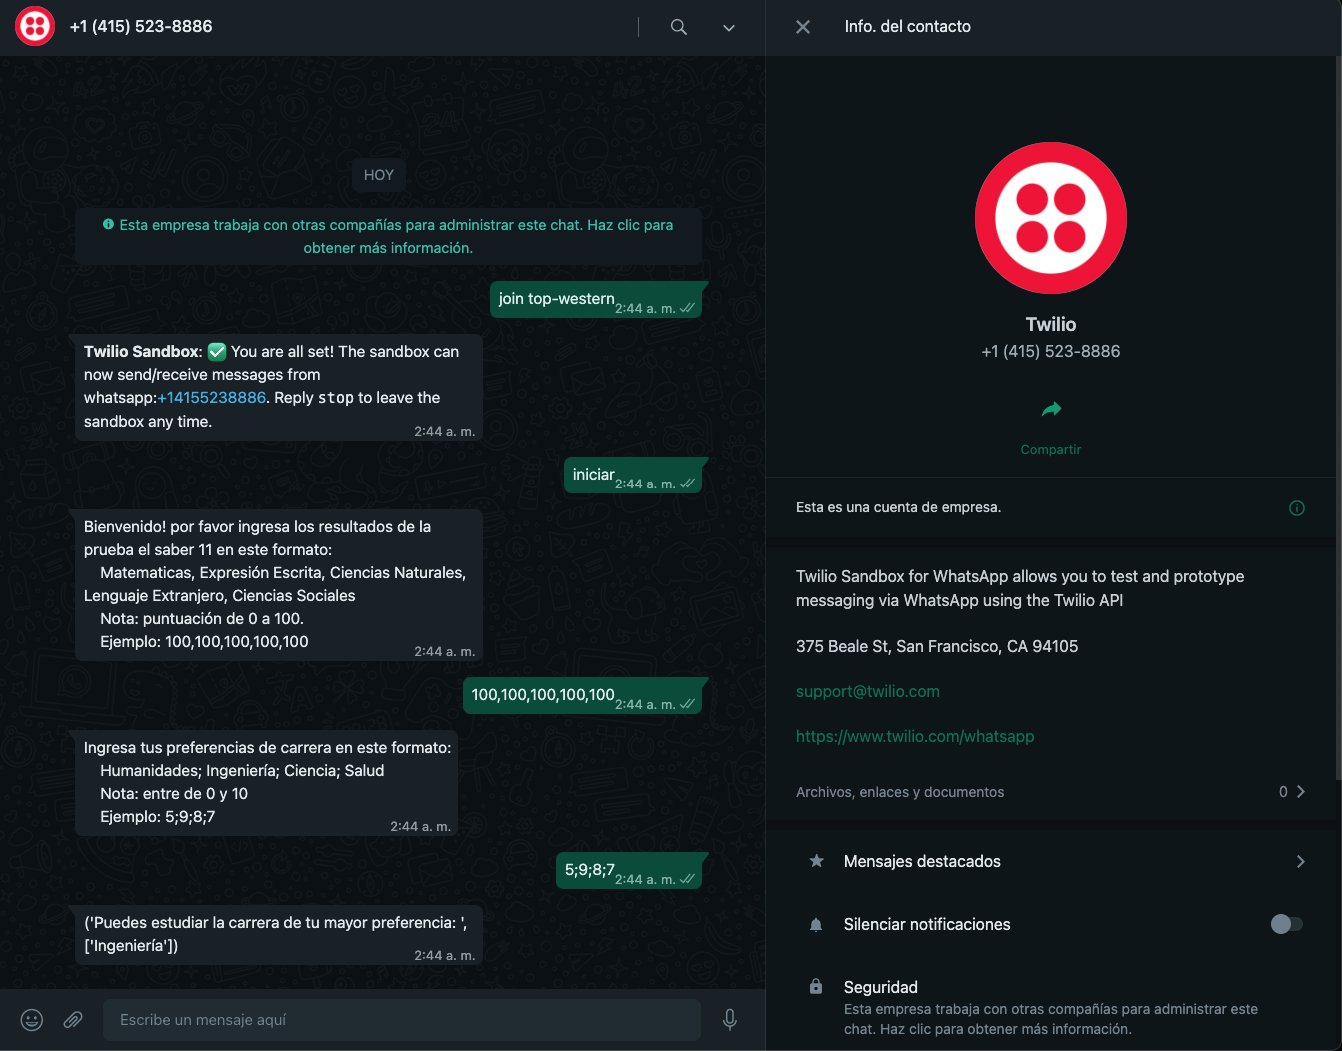

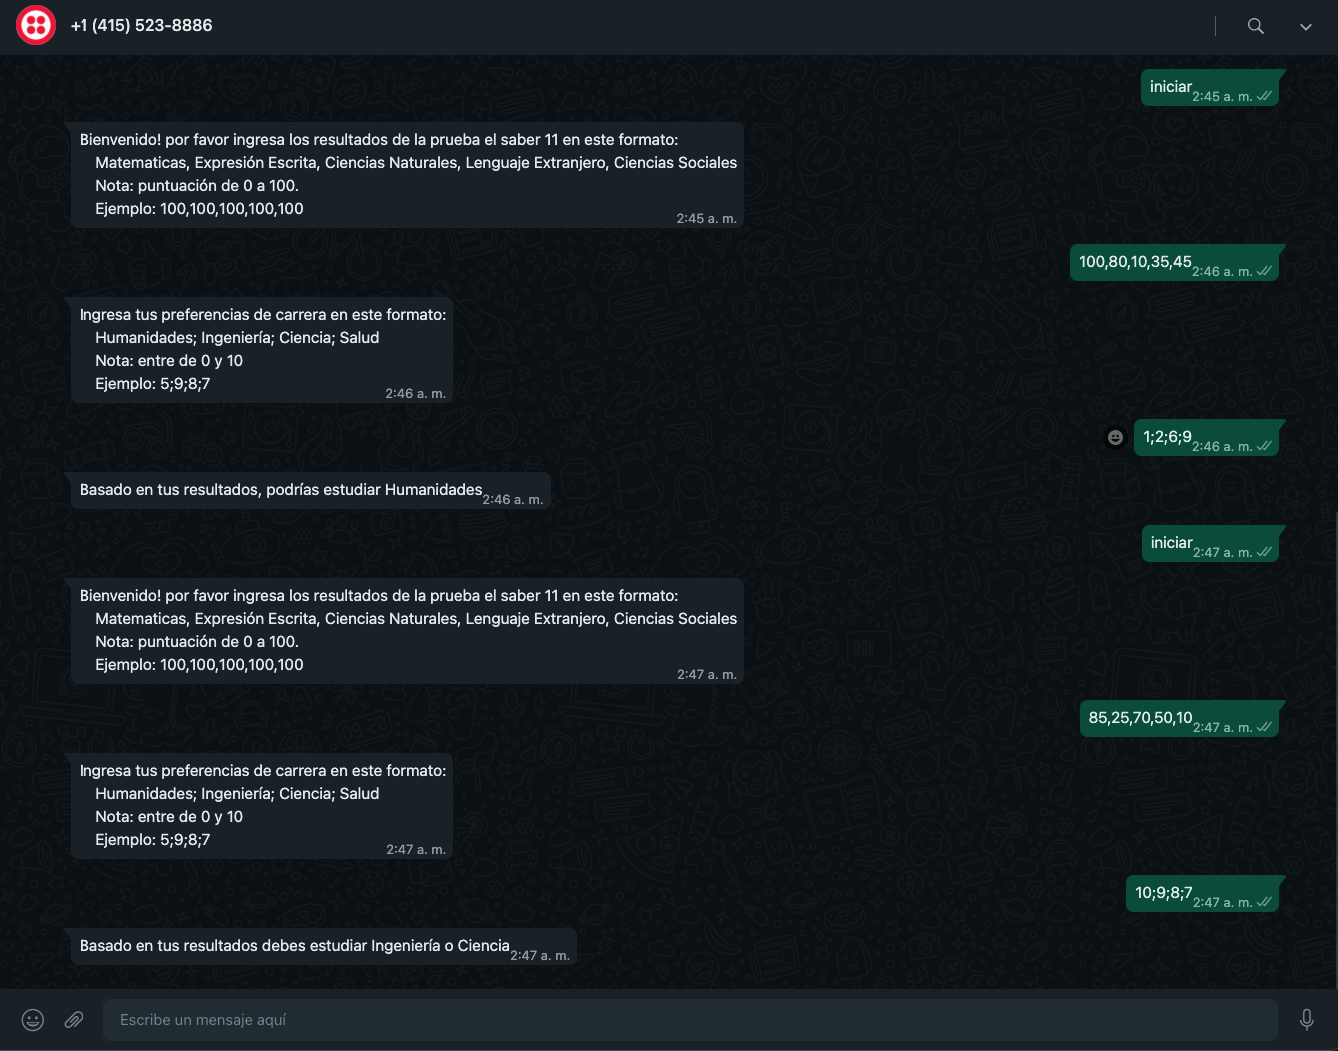